# Proyecto Final Algebra Lineal 2017
---

El proyecto del curso consiste en la implementación del [Algortimo de Canny](https://es.wikipedia.org/wiki/Algoritmo_de_Canny) para la detección de bordes en imágenes y videos. Para ello, se le entrega al estudiante toda la implementación del algoritmo en [OpenCV](http://opencv.org/) y su objetivo es **implementar las funciones de OpenCV con matrices**. 

Las funciones a modificar serán las siguientes:
```python
cv2.GaussianBlur()
cv2.Sobel()
```

No es necesario que modifique más del código que se le solicita, pero puede hacer las modificaciones pertinentes si ese fuera el caso. Dentro del código se le indica en qué parte debe de ser modificado, por ejemplo:

```python
'''Modificar esta función'''
    sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
``` 

Se recomienda buscar maneras de optimizar los cálculos de sus filtros, pues más adelante existe una aplicación en tiempo real donde es crucial que sus cálculos sean lo más rápidos posibles. Las dimensiones de los *kernels* no pueden ser modificadas.

## 0. Conceptos
Para poder modificar las funciones solicitadas es necesario que comprenda algunos conceptos, por lo cual es necesario que defina:

1. ¿En que consiste la convolución y cómo puede ser calculada? (Puede dar una definición matemática y/o ejemplos).

2. ¿Qué es el *kernel* de un filtro y para que se utiliza?

3. ¿En qué consiste un filtro Gaussiano?

4. ¿En qué consiste el Filtro Sobel? ¿para qué sirve?

3. Describa el algoritmo de detección de bordes Canny.

In [1]:
import numpy as np
import matplotlib.pylab as plt
import cv2

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [8]:
def gaussian_kernel():
    '''My function'''
    kernel = np.matrix([[1,4,7,4,1],[4,20,33,20,4],[7,33,55,7,33],[4,20,33,20,4],[1,4,7,4,1]])
    #kernel = np.matrix([[-1,-4,-7,-4,-1],[-4,-20,-33,-20,-4],[-7,-33,-55,-7,-33],[-4,-20,-33,-20,-4],[-1,-4,-7,-4,-1]])
    return kernel

def sobelx_kernel():
    '''My function'''
    kernel = np.matrix([[-3,0,3],[-10,0,10],[-3,0,3]])
    return kernel
def sobely_kernel():
    '''My function'''
    kernel = np.matrix([[-3,-10,-3],[0,0,0],[3,10,3]])
    return kernel

def gaussian_blur(img, kernel=5):
    '''Modificar esta función'''
    kernel_matrix = gaussian_kernel()
    new_img = np.zeros((img.shape[0]-2,img.shape[1]-2))
    kernel_sum = np.sum(kernel_matrix)
    for row in range(2, img.shape[0]-2):
        for column in range(2, img.shape[1]-2):
            #create the current pixel matrix
            current_matrix = [[img[row-2,column-2], img[row-2, column-1], img[row-2,column],img[row-2,column+1],img[row-2,column+2]],
                             [img[row-1,column-2], img[row-1, column-1], img[row-1,column],img[row-1,column+1],img[row-1,column+2]],
                             [img[row,column-2], img[row, column-1], img[row,column],img[row,column+1],img[row,column+2]],
                             [img[row+1,column-2], img[row+1, column-1], img[row+1,column],img[row+1,column+1],img[row+1,column+2]],
                             [img[row+2,column-2], img[row+2, column-1], img[row+2,column],img[row+2,column+1],img[row+2,column+2]]]
            #current matrix is multiplicated with the kernel, element to element
            current_matrix = np.multiply(current_matrix, kernel_matrix)
            #summing current matrix elements
            current_sum = np.sum(current_matrix)
            #dividing the current sum and kernel sum and sustituded and replacing the pixel value
            new_img[row-2,column-2] = current_sum/kernel_sum

    return new_img #return cv2.GaussianBlur(img,(kernel,kernel),0)
    
def sobel_filter(img, kernel_matrix):
    kernel_sum = n.sum(kernel_matrix)
    new_img = np.zeros((img.shape[0]-1,img.shape[1]-1))
    for row in range(1, img.shape[0]-1):
        for column in range(1, img.shape[1]-1):
            #create the current matrix
            current_matrix = [[img[row-1,column-1],img[row-1,column],img[row-1,column+1]],
                             [img[row,column-1],img[row,column],img[row,column+1]],
                             [img[row+1,column-1],img[row+1,column],img[row+1,column+1]]]
            #current matrix is multiplicated with the kernel, element to element
            current_matrix = np.multiply(current_matrix, kernel_matrix)
            #summing current matrix elements
            current_sum = np.sum(current_matrix)
            #dividing the current sum and kernel sum and sustituded and replacing the pixel value
            new_img[row-1,column-1] = current_sum/kernel_sum

    return new_img

    
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    if orient == 'x':
        x,y = 1,0
    elif orient == 'y':
        x,y = 0,1
        
    '''Modificar esta función'''
    sobel = cv2.Sobel(img, cv2.CV_64F, x, y, ksize=sobel_kernel)
    
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)

    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return sbinary

def mag_thresh(image, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Take the gradient in x and y separately
    '''Modificar esta función'''
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    '''Modificar esta función'''
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the magnitude 
    abs_sobel = np.sqrt(sobelx**2 +sobely**2)

    # Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    return sbinary

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Take the gradient in x and y separately
    '''Modificar esta función'''
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    '''Modificar esta función'''
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)

    # Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)   
    abs_sobely = np.absolute(sobely)
    
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    
    # Create a binary mask where direction thresholds are met
    sbinary = np.zeros_like(grad_dir)
    sbinary[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    return sbinary

In [ ]:
#pruebas borrar al final esta celda
im = plt.imread("Gato.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)
gray = gaussian_blur(gray, kernel = 5)

f, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax2.imshow(cv2.cvtColor(im, cv2.COLOR_RGB2GRAY),cmap='gray')
ax3.imshow(gray, cmap='gray')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

## 1. Prueba en Imagen

In [9]:
# Test filter on single image
im = plt.imread("Gato.jpg")
gray = cv2.cvtColor(im, cv2.COLOR_RGB2GRAY)

# Gaussian Blur Filtering
gray = gaussian_blur(gray, kernel = 5)

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/2))

# Create combined image with sobel filters applied
combined = np.zeros_like(dir_binary)
combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.float64)

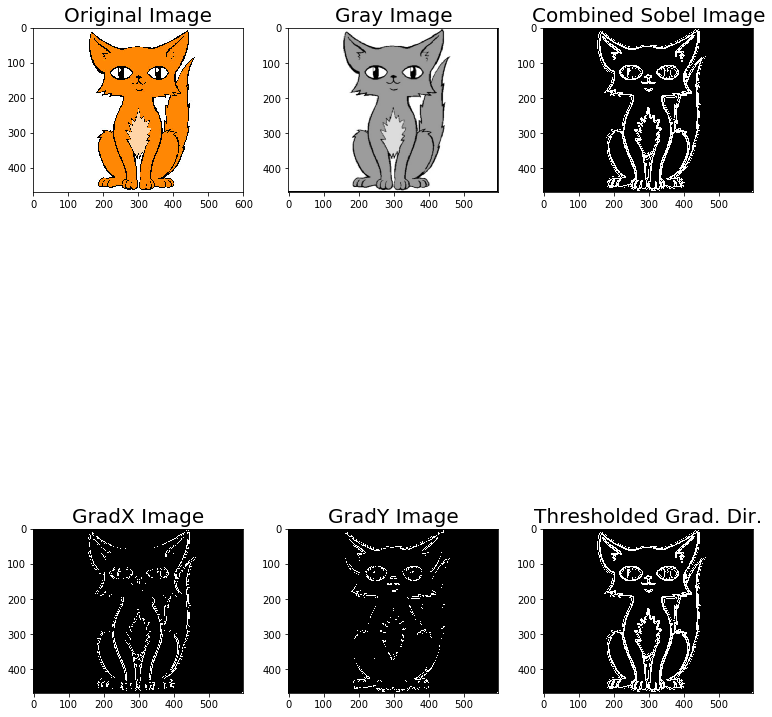

In [10]:
# Plot the result
f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(10, 15))
f.tight_layout()
ax1.imshow(im)
ax1.set_title('Original Image', fontsize=20)
ax2.imshow(gray, cmap='gray')
ax2.set_title('Gray Image', fontsize=20)
ax3.imshow(rgb_combined, cmap='gray')
ax3.set_title('Combined Sobel Image', fontsize=20)
ax4.imshow(gradx, cmap='gray')
ax4.set_title('GradX Image', fontsize=20)
ax5.imshow(grady, cmap='gray')
ax5.set_title('GradY Image', fontsize=20)
ax6.imshow(((mag_binary == 1) & (dir_binary == 1)), cmap='gray')
ax6.set_title('Thresholded Grad. Dir.', fontsize=20)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show() 

## 2. Prueba en Videos

In [ ]:
def process_image(image):
    
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    gray = gaussian_blur(gray, kernel = 5)
    # Choose a Sobel kernel size
    ksize = 3 # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(20, 100))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0, np.pi/4))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    
    rgb_combined = np.asarray(np.dstack((combined, combined, combined)), dtype=np.uint8)
    
    retval, threshold = cv2.threshold(rgb_combined, 0, 255, cv2.THRESH_BINARY)
    
    return threshold

In [ ]:
filter_output = 'Batman_Filter.mp4'
clip1 = VideoFileClip("Batman.mp4")
batman_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time batman_clip.write_videofile(filter_output, audio=False)

In [ ]:
HTML("""
<video width="720" height="480" controls>
  <source src="{0}">
</video>
""".format(filter_output))

In [ ]:
cap = cv2.VideoCapture(0)  # 0 for Python 3, 1 for Python 2. No idea why?!!

fourcc = cv2.cv.CV_FOURCC(*"MJPG")

#out = cv2.VideoWriter("output.avi", cv2.VideoWriter_fourcc(*"MJPG"), 20,(640,480))
out = cv2.VideoWriter("output.avi", fourcc, 20,(640,480))


while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        frame = cv2.flip(frame,180)
        new_frame = process_image(frame)
        out.write(new_frame)

        cv2.imshow('frame',new_frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()